In [62]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import mode
from scipy.stats import truncnorm

read set price

In [63]:
df = pd.read_csv('SET 50 Historical Data (6).csv')

In [64]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)
df

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2021-01-04,924.36,896.70,924.36,893.62,2.76B,1.53%
2021-01-05,953.99,923.20,953.99,921.51,2.93B,3.21%
2021-01-06,940.41,951.94,957.42,935.88,3.41B,-1.42%
2021-01-07,955.39,952.69,959.29,946.05,4.56B,1.59%
2021-01-08,977.59,965.70,977.59,964.91,3.00B,2.32%
...,...,...,...,...,...,...
2025-05-07,793.73,777.89,793.73,775.73,2.23B,3.14%
2025-05-08,783.61,791.22,794.31,783.07,1.94B,-1.27%
2025-05-09,789.38,788.37,791.19,776.85,1.82B,0.74%


simulation

In [65]:
S0 = float(df['Price'].iloc[-1]) 
n_days = 2
n_sim = 500
cap = 0.3        
trend_strength = -0.2  # bias
S0

793.9

In [66]:
simulated_paths = np.zeros((n_sim, n_days + 1))
simulated_paths[:, 0] = S0 

In [67]:
for t in range(1, n_days + 1):
    true_pct_cap = 0.3
    log_cap = np.log(1 + true_pct_cap)  # ≈ 0.262
    low = max(-log_cap, -log_cap + trend_strength)
    high = min(log_cap, log_cap + trend_strength)

    shocks = np.random.uniform(low, high, size=n_sim)
    simulated_paths[:, t] = simulated_paths[:, t - 1] * np.exp(shocks)



In [68]:
columns = [f"Day_{i}" for i in range(n_days + 1)]
df_sim = pd.DataFrame(simulated_paths, columns=columns)
df_sim

,Day_0,Day_1,Day_2
0,793.9,792.001710,783.190987
1,793.9,737.978494,584.513491
2,793.9,659.026201,507.127434
3,793.9,617.635208,523.096351
4,793.9,667.978073,585.347490
...,...,...,...
495,793.9,621.910943,506.709342
496,793.9,696.033226,709.153653
497,793.9,766.197075,801.690630
498,793.9,693.884747,597.556051


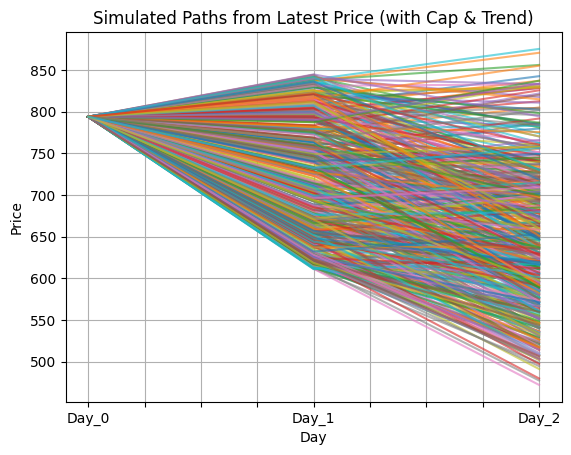

In [69]:
df_sim.T.plot(legend=False, alpha=0.6)
plt.title("Simulated Paths from Latest Price (with Cap & Trend)")
plt.xlabel("Day")
plt.ylabel("Price")
plt.grid(True)
plt.show()

In [93]:
true_pct_cap = 0.3
log_cap = np.log(1 + true_pct_cap)
cap_line = [S0 * np.exp(log_cap * -i) for i in range(n_days + 1)]

<Figure size 1400x600 with 0 Axes>

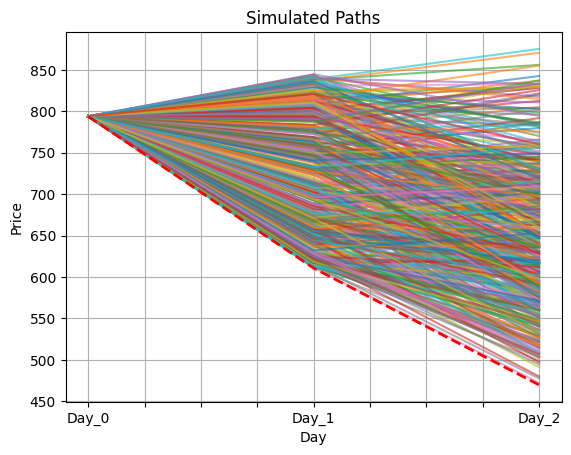

In [94]:
plt.figure(figsize=(14, 6))
df_sim.T.plot(legend=False, alpha=0.6)
plt.plot(cap_line, linestyle='--', color='red', linewidth=2, label='+30% per day')
plt.title("Simulated Paths")
plt.xlabel("Day")
plt.ylabel("Price")
plt.grid(True)
#plt.legend()
plt.show()

In [72]:
df_pct_change = df_sim.pct_change(axis=1)
df_log_return = np.log(df_sim.div(df_sim.shift(axis=1)))
df_pct_change.describe()

,Day_0,Day_1,Day_2
count,0.0,500.000000,500.000000
mean,NaN,-0.097618,-0.096153
std,NaN,0.084994,0.085349
min,NaN,-0.230354,-0.230638
25%,NaN,-0.168421,-0.169616
50%,NaN,-0.106086,-0.100155
75%,NaN,-0.024227,-0.023044
max,NaN,0.063961,0.063130


ทดสอบ simulation

In [73]:
# แปลงจาก %cap → log-return cap
true_pct_cap = 0.3
log_cap = np.log(1 + true_pct_cap)

def get_trunc_shocks(mean=0.1, sd=0.1, low=-0.3, upp=0.3, size=1000):
    return truncnorm(
        (low - mean)/sd, (upp - mean)/sd, loc=mean, scale=sd
    ).rvs(size)

# Simulation
simulated_paths_tun = np.zeros((n_sim, n_days + 1))
simulated_paths_tun[:, 0] = S0

for t in range(1, n_days + 1):
    shocks = get_trunc_shocks(
        mean=trend_strength, sd=0.1,
        low=-log_cap, upp=log_cap, size=n_sim
    )
    simulated_paths_tun[:, t] = simulated_paths_tun[:, t - 1] * np.exp(shocks)

df_sim_tun = pd.DataFrame(simulated_paths_tun, columns=columns)

In [74]:
simulated_paths_norm = np.zeros((n_sim, n_days + 1))
simulated_paths_norm[:, 0] = S0

for t in range(1, n_days + 1):
    shocks = np.random.normal(loc=trend_strength, scale=0.1, size=n_sim)
    shocks = np.clip(shocks, -log_cap, log_cap)  # ใช้ log_cap แทน cap เดิม
    simulated_paths_norm[:, t] = simulated_paths_norm[:, t - 1] * np.exp(shocks)

df_sim_norm = pd.DataFrame(simulated_paths_norm, columns=columns)


<Figure size 1200x600 with 0 Axes>

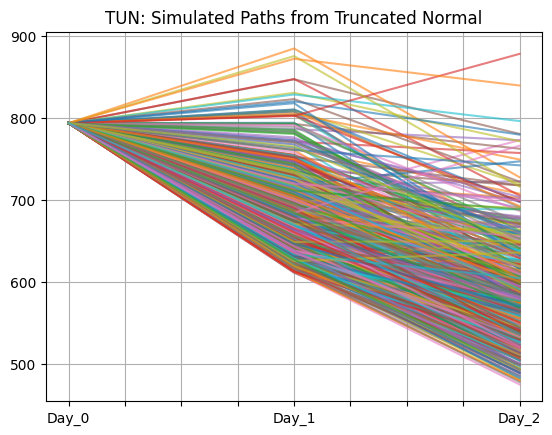

<Figure size 1200x600 with 0 Axes>

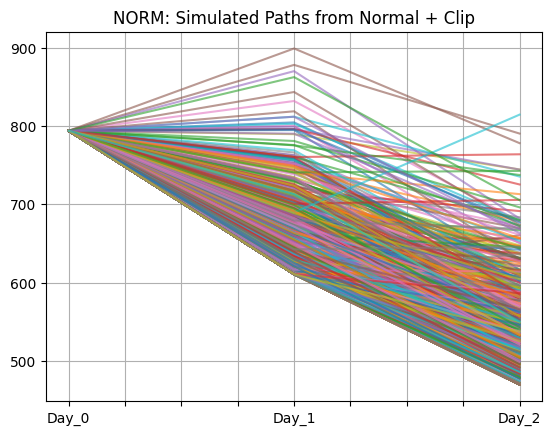

In [75]:
plt.figure(figsize=(12, 6))
df_sim_tun.T.plot(legend=False, alpha=0.6)
plt.title("TUN: Simulated Paths from Truncated Normal")
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
df_sim_norm.T.plot(legend=False, alpha=0.6)
plt.title("NORM: Simulated Paths from Normal + Clip")
plt.grid(True)
plt.show()

In [76]:
print("จำนวนเส้นที่ไม่ซ้ำกันทั้งหมด:", df_sim.drop_duplicates().shape[0])

จำนวนเส้นที่ไม่ซ้ำกันทั้งหมด: 500


<Figure size 1200x600 with 0 Axes>

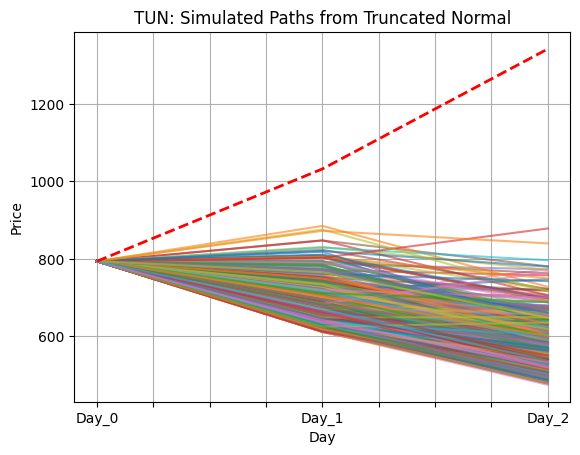

<Figure size 1200x600 with 0 Axes>

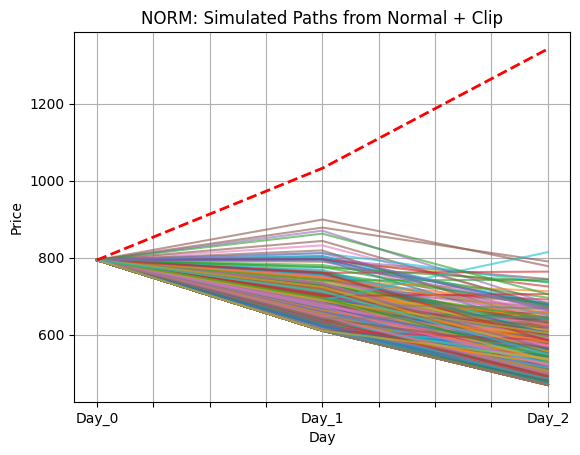

In [77]:
# คำนวณเส้น cap


# --- Plot TUN ---
plt.figure(figsize=(12, 6))
df_sim_tun.T.plot(legend=False, alpha=0.6)
plt.plot(cap_line, linestyle='--', color='red', linewidth=2, label='+30% per day')
plt.title("TUN: Simulated Paths from Truncated Normal")
plt.xlabel("Day")
plt.ylabel("Price")
plt.grid(True)
#plt.legend()
plt.show()

# --- Plot Normal ---
plt.figure(figsize=(12, 6))
df_sim_norm.T.plot(legend=False, alpha=0.6)
plt.plot(cap_line, linestyle='--', color='red', linewidth=2, label='+30% per day')
plt.title("NORM: Simulated Paths from Normal + Clip")
plt.xlabel("Day")
plt.ylabel("Price")
plt.grid(True)
#plt.legend()
plt.show()


In [78]:
cap_line

[793.9, 1032.07, 1341.691]

คำนวนหา strike ในวันแรก

In [79]:
S0_rounded = round(S0 / 25) * 25
n_steps = 8
strike_range = np.arange(-n_steps, n_steps + 1) * 25
strike_list = S0_rounded + strike_range

print("S0:", S0)
print("S0 rounded to nearest 25:", S0_rounded)
print("Strike prices:", strike_list)

S0: 793.9
S0 rounded to nearest 25: 800
Strike prices: [ 600  625  650  675  700  725  750  775  800  825  850  875  900  925
  950  975 1000]


Naive Bays

In [80]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [81]:
df_price = df[['Price']].copy()
df_price['Price'] = df_price['Price'].str.replace(',', '').astype(float)

In [82]:
window_size = 5
for i in range(1, window_size + 1):
    df_price[f'Return_lag_{i}'] = df_price['Price'].pct_change(i)

In [83]:
df_price['Next_Price'] = df_price['Price'].shift(-1)
bin_edges = np.arange(600, 1100 + 1, 25)
df_price['Price_Bin'] = pd.cut(df_price['Next_Price'], bins=bin_edges, labels=False)

In [84]:
df_price.dropna(inplace=True)
X = df_price[[f'Return_lag_{i}' for i in range(1, window_size + 1)]].values
y = df_price['Price_Bin'].values

In [85]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [86]:
model = GaussianNB()
model.fit(X_scaled, y)

GaussianNB()

In [87]:
sim_prices = df_sim.iloc[:, -1].values.reshape(-1, 1)

In [88]:
sim_features = np.zeros((len(sim_prices), window_size))
sim_features_scaled = scaler.transform(sim_features)

In [89]:
sim_bin_probs = model.predict_proba(sim_features_scaled)

In [90]:
sim_bin_index = np.digitize(sim_prices.flatten(), bin_edges) - 1
sim_bin_index = np.clip(sim_bin_index, 0, sim_bin_probs.shape[1] - 1)

In [91]:
prob_sim_realistic = [sim_bin_probs[i, b] for i, b in enumerate(sim_bin_index)]

result_df = pd.DataFrame({
    'Simulated_Price': sim_prices.flatten(),
    'Prob_Historical_Occurrence': prob_sim_realistic
})

print(result_df.head(10))

   Simulated_Price  Prob_Historical_Occurrence
0       783.190987                6.193201e-02
1       584.513491                9.677252e-35
2       507.127434                9.677252e-35
3       523.096351                9.677252e-35
4       585.347490                9.677252e-35
5       580.059425                9.677252e-35
6       744.840045                2.884607e-02
7       477.506130                9.677252e-35
8       523.084443                9.677252e-35
9       600.039791                9.677252e-35


In [92]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler

# --- STEP 1: เตรียม historical price (df_price) ---
df_price = df[['Price']].copy()
df_price['Price'] = df_price['Price'].str.replace(',', '').astype(float)

# --- STEP 2: สร้าง Return Lag Feature ---
window_size = 5
for i in range(1, window_size + 1):
    df_price[f'Return_lag_{i}'] = df_price['Price'].pct_change(i)

# --- STEP 3: สร้างราคาวันถัดไป (Target) และ Bin ---
df_price['Next_Price'] = df_price['Price'].shift(-1)
bin_edges = np.arange(600, 1100 + 1, 25)
df_price['Price_Bin'] = pd.cut(df_price['Next_Price'], bins=bin_edges, labels=False)

# --- STEP 4: เตรียม Data ---
df_price.dropna(inplace=True)
X = df_price[[f'Return_lag_{i}' for i in range(1, window_size + 1)]].values
y = df_price['Price_Bin'].values

# --- STEP 5: Train Naive Bayes ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

model = GaussianNB()
model.fit(X_scaled, y)

# --- STEP 6: เตรียม simulation price ล่าสุด (จาก df_sim) ---
# ใช้แค่วันสุดท้าย
sim_prices = df_sim.iloc[:, -1].values.reshape(-1, 1)  # shape (n_sim, 1)

# --- STEP 7: สร้าง feature เหมือน historical (dummy return lags = 0) ---
# ในภาคจริงควรใช้ข้อมูลจริงก่อนหน้าเพื่อสร้าง lag แต่ตอนนี้ใช้ dummy zero แทน (จำลอง idea)
sim_features = np.zeros((len(sim_prices), window_size))

# scale เหมือน historical
sim_features_scaled = scaler.transform(sim_features)

# --- STEP 8: ทำนาย Probabilities ว่าแต่ละ simulation อยู่ bin ไหน ---
sim_bin_probs = model.predict_proba(sim_features_scaled)

# --- STEP 9: หา bin ที่ราคา simulation แต่ละตัวอยู่จริง ๆ ---
sim_bin_index = np.digitize(sim_prices.flatten(), bin_edges) - 1
sim_bin_index = np.clip(sim_bin_index, 0, sim_bin_probs.shape[1] - 1)

# --- STEP 10: ดึงโอกาสเกิดจริงของราคาที่ simulate มา ---
prob_sim_realistic = [sim_bin_probs[i, b] for i, b in enumerate(sim_bin_index)]

# --- สรุปผลใส่ DataFrame ---
result_df = pd.DataFrame({
    'Simulated_Price': sim_prices.flatten(),
    'Prob_Historical_Occurrence': prob_sim_realistic
})

import ace_tools as tools; tools.display_dataframe_to_user(name="Simulation Occurrence Probability", dataframe=result_df)


ModuleNotFoundError: No module named 'ace_tools'